# Car Vs Ambulance classification using ensemble CNN


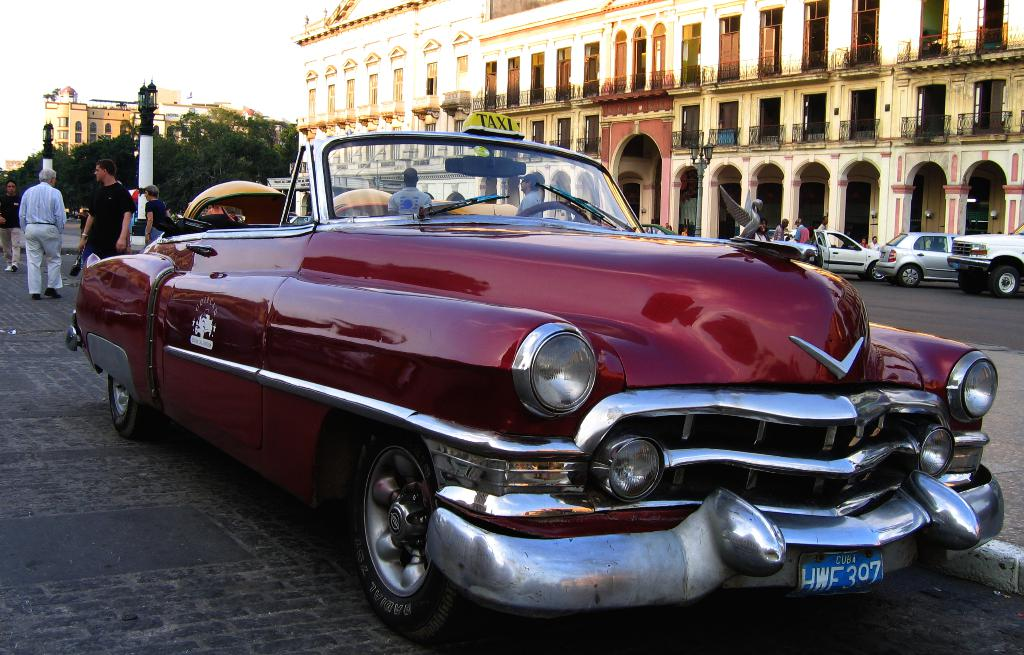

## 1. **Introduction**
Here’s a bullet-point description of the dataset:

### About Dataset
**Source of the Dataset** : [image-classification-and-yolo-dataset](https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data) \
**Classes**: Contains images of two primary classes: cars and ambulances. \
**Diversity**: Images include various angles, lighting conditions, and backgrounds.  \
**Labeling**: Each image is labeled for accurate classification and detection. \

**Applications**: \
**Image classification**: Identifying whether an image contains a car or an ambulance. \
**Object detection**: Locating and recognizing cars and ambulances within images. \
**Use Cases**: Ideal for projects such as traffic monitoring, emergency vehicle detection, and automated vehicle recognition systems. \
               Train file is for different types of Cars and Ambulances images. \
               Label file for the labels,which show the labels regarding about the images. 


## Planning
* Dataset also contain coordinates for each object in the image
* First I will try to work on only Object classification problem
* Then i will try to use those coordinates and make this problem as an Object detection

## 2. Data Preparation

In [1]:
%pwd

'/workspaces/car_vs_ambulance_classification_ensemble_cnn/notebooks'

In [2]:
# Go to project root folder
import os
os.chdir("../")
%pwd


'/workspaces/car_vs_ambulance_classification_ensemble_cnn'

In [3]:
# automatically reload all modules before executing
%load_ext autoreload
%autoreload 2 

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU'), tf.__version__

2024-10-13 08:52:41.342179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 08:52:41.417934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 08:52:41.439906: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 08:52:41.590562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1728809564.010148    2691 cuda_executor.c

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.17.0')

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import opendatasets as od
import random
import pathlib
import os

In [6]:
from utils import utils

### Config load

In [14]:
params_config_path = 'params.yaml'
params_config = utils.read_yaml(yaml_path=params_config_path)
params_config

2024-10-13 08:54:45,308 — utils.utils — INFO — yaml file: <_io.TextIOWrapper name='params.yaml' mode='r' encoding='UTF-8'> loaded successfully


ConfigBox({'base': {'random_seed': 42}, 'data_split': {'test_size': 0.2}, 'train': {'image_size': 224, 'batch_size': 32, 'loss': 'binary_crossentropy', 'if_fine_tune': True, 'fine_tune_args': {'models': ['lenet', 'mini_vgg_net', 'shallownet'], 'lr': {'max': 0.01, 'min': 0.0001}, 'epochs': 2, 'optimizers': ['adam', 'sgd']}, 'lenet': {'base_lr': 0.01, 'epochs': 2}, 'mini_vgg_net': {'base_lr': 0.01, 'epochs': 10}, 'shallownet': {'base_lr': 0.01, 'epochs': 10}}, 'evaluate': {'metrics': ['accuracy', 'precision', 'recall'], 'reports_dir': 'src/reports', 'results_dir': 'src/reports/results', 'confusion_matrix_image': 'confusion_matrix.png'}, 'paths': {'dataset_url': 'https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data', 'raw_dataset_dir': 'dataset/raw', 'dataset_path': 'dataset/image-classification-and-yolo-dataset/Ambulance_Car', 'preprocess_dataset': 'dataset/preprocess', 'train_dir': 'dataset/raw/image-classification-and-yolo-dataset/Ambulance_Car/Tr

In [10]:
tf.random.set_seed(params_config.base.random_seed)

In [11]:
params_config

ConfigBox({'base': {'random_seed': 42}, 'data_split': {'test_size': 0.2}, 'train': {'image_size': 224, 'batch_size': 32, 'loss': 'binary_crossentropy', 'if_fine_tune': True, 'fine_tune_args': {'models': ['lenet', 'mini_vgg_net', 'shallownet'], 'lr': {'max': 0.01, 'min': 0.0001}, 'epochs': 2, 'optimizers': ['adam', 'sgd']}, 'lenet': {'base_lr': 0.01, 'epochs': 2}, 'mini_vgg_net': {'base_lr': 0.01, 'epochs': 10}, 'shallownet': {'base_lr': 0.01, 'epochs': 10}}, 'evaluate': {'metrics': ['accuracy', 'precision', 'recall'], 'reports_dir': 'src/reports', 'results_dir': 'src/reports/results', 'confusion_matrix_image': 'confusion_matrix.png'}, 'paths': {'dataset_url': 'https://www.kaggle.com/datasets/amansingh0000000/image-classification-and-yolo-dataset/data', 'raw_dataset_dir': 'dataset/raw', 'dataset_path': 'dataset/image-classification-and-yolo-dataset/Ambulance_Car', 'preprocess_dataset': 'dataset/preprocess', 'train_dir': 'dataset/raw/image-classification-and-yolo-dataset/Ambulance_Car/Tr

In [12]:
# Dowload the dataset
utils.download_datasets_from_kaggle('params.yaml')

2024-10-13 08:53:34,424 — utils.utils — INFO — yaml file: <_io.TextIOWrapper name='params.yaml' mode='r' encoding='UTF-8'> loaded successfully
2024-10-13 08:53:34,425 — utils.utils — INFO — Raw dataset url: dataset/raw
Skipping, found downloaded files in "dataset/raw/image-classification-and-yolo-dataset" (use force=True to force download)


I. Quick look at the downloaded data

In [15]:
train_dir = params_config.paths.train_dir
lables_dir = params_config.paths.labels_dir

In [16]:
len(os.listdir(train_dir)), len(os.listdir(lables_dir))

(1138, 1138)

II. Load data into the memory

In [17]:
import glob
import cv2

images = []
labels = []
IMAGE_SIZE = params_config.train.image_size
for _image_path in glob.glob(train_dir+"/*.jpg"):
    _img = cv2.imread(filename=_image_path)
    _img = cv2.resize(_img, (IMAGE_SIZE, IMAGE_SIZE))
    # print(_image_path)
    file_name_without_ext = _image_path.split('/')[-1].split('.')[0]
    label_file = f'{lables_dir}/{file_name_without_ext}.txt'
    # print(label_file)
    with open(label_file, 'r') as _labels:
        for line in _labels.readlines():
            _label, x_min, y_min, x_max, y_max = line.split()
            labels.append(_label)
            images.append(_img)
            # print(_label)

In [18]:
len(images), len(labels)

(2784, 2784)

In [19]:
def plot_images_with_label(images, labels):
    random_nums = random.sample(range(0, len(images)), 6)
    for idx, rand_num in enumerate(random_nums):
        plt.subplot(3, 3, idx+1)
        plt.imshow(images[rand_num])
        plt.title(labels[rand_num])
        plt.axis('off')
    plt.show()

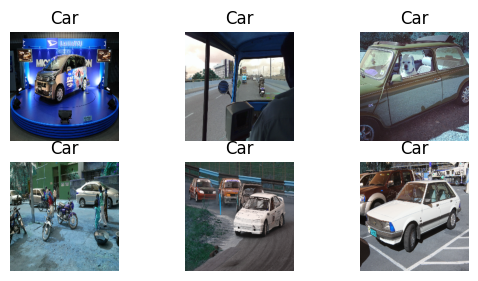

In [20]:
plot_images_with_label(images, labels)

### Data transforms (normalization & data augmentation)

Dataset split for training and testing

In [21]:
import numpy as np
images_arr = np.array(images)
labels_arr = np.array(labels)
images_arr.shape, labels_arr.shape

((2784, 224, 224, 3), (2784,))

In [22]:
images_arr[0]

array([[[ 84,  99,  98],
        [ 83,  95,  99],
        [ 87, 106, 103],
        ...,
        [ 55,  43,  33],
        [ 50,  37,  29],
        [ 48,  35,  27]],

       [[ 81, 102, 107],
        [ 93, 104, 113],
        [ 87,  99,  99],
        ...,
        [ 50,  38,  29],
        [ 49,  36,  28],
        [ 50,  37,  29]],

       [[ 88, 100, 100],
        [ 92, 106, 108],
        [ 90,  97, 100],
        ...,
        [ 50,  38,  32],
        [ 56,  40,  33],
        [ 54,  39,  33]],

       ...,

       [[ 38,  37,  33],
        [ 21,  20,  16],
        [  5,   5,   5],
        ...,
        [ 42,  40,  37],
        [ 46,  45,  41],
        [ 40,  40,  35]],

       [[  2,   1,   1],
        [ 15,  17,  14],
        [  9,   7,   7],
        ...,
        [ 40,  39,  36],
        [ 43,  43,  39],
        [ 42,  42,  36]],

       [[ 55,  49,  43],
        [ 30,  29,  28],
        [ 12,  12,  12],
        ...,
        [ 43,  43,  37],
        [ 39,  37,  36],
        [ 44,  44,  38]]

In [23]:
labels_arr[:5]

array(['Car', 'Car', 'Car', 'Car', 'Car'], dtype='<U9')

In [24]:
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomBrightness, RandomContrast

#### LabelEncoder

In [25]:
from sklearn.calibration import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels_arr)
label_names = list(label_encoder.classes_)
encoded_labels[:5], label_names

(array([1, 1, 1, 1, 1]), ['Ambulance', 'Car'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(images_arr,
                                                    encoded_labels,
                                                    test_size=params_config.data_split.test_size,
                                                    shuffle=True,
                                                    random_state=params_config.base.random_seed)
len(X_train), len(X_test)

(2227, 557)

In [27]:
#  Convert the split data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(
    buffer_size=1000).batch(params_config.train.batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).batch(params_config.train.batch_size)

# Prefetch to optimize performance
train_dataset_prefetch = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset_prefech = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

I0000 00:00:1728809697.473387    2691 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728809697.475790    2691 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728809697.477638    2691 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728809697.597302    2691 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [28]:
rescale = tf.keras.Sequential([
    Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
])

In [29]:
image, label = next(iter(train_dataset_prefetch))
result = rescale(image)
result

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.47058827, 0.43137258, 0.43529415],
         [0.47450984, 0.48235297, 0.4784314 ],
         [0.38823533, 0.37254903, 0.3803922 ],
         ...,
         [0.45098042, 0.4666667 , 0.49411768],
         [0.43137258, 0.45882356, 0.47450984],
         [0.427451  , 0.45882356, 0.45882356]],

        [[0.3921569 , 0.31764707, 0.32941177],
         [0.4901961 , 0.4431373 , 0.45098042],
         [0.5058824 , 0.50980395, 0.5058824 ],
         ...,
         [0.46274513, 0.49411768, 0.49411768],
         [0.454902  , 0.48627454, 0.49803925],
         [0.4431373 , 0.4784314 , 0.49411768]],

        [[0.39607847, 0.43137258, 0.43529415],
         [0.3647059 , 0.27450982, 0.29411766],
         [0.5176471 , 0.46274513, 0.4666667 ],
         ...,
         [0.45882356, 0.4901961 , 0.4901961 ],
         [0.4666667 , 0.48627454, 0.49803925],
         [0.4431373 , 0.4784314 , 0.4901961 ]],

        ...,

        [[0.5647059 , 0.5411765 ,

In [30]:
aug_img = data_augmentation(result)
aug_img[0].shape

TensorShape([224, 224, 3])

(-0.5, 223.5, 223.5, -0.5)

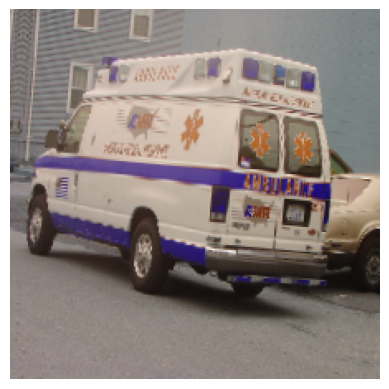

In [31]:
plt.imshow(aug_img[0])
plt.axis("off")

In [32]:
# reference https://www.datacamp.com/tutorial/complete-guide-data-augmentation
train_dataset_prefetch = train_dataset_prefetch.map(
    lambda x, y: (rescale(x, training=True), y))

In [33]:

train_dataset_prefetch = train_dataset_prefetch.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [36]:
for i, (images, labels) in enumerate(train_dataset_prefetch):
    for b_img, b_label in zip(images, labels):
        print(b_label == 1, label_names[b_label])
        dir_path = os.path.join(
            params_config.paths.preprocess_dataset, label_names[b_label])
        print(dir_path)
        os.makedirs(dir_path, exist_ok=True)
        image_path = os.path.join(
            dir_path, f'{label_names[b_label].lower()}_{i}.png')
        tf.keras.preprocessing.image.save_img(image_path, b_img.numpy())

tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(True, shape=(), dtype=bool) Car
dataset/preprocess/Car
tf.Tensor(False, shape=(), dtype=bool) Ambulance
dataset/preprocess/Ambulance
tf.Tensor(Tr

2024-10-13 08:56:30.587308: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
val_dataset_prefech = val_dataset_prefech.map(
    lambda x, y: (rescale(x, training=True), y))

## Model 1 - MiniVGGNet

### MiniVGGNet Build

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Input

In [27]:

class MiniVGGNet:
    @staticmethod
    def build(width: int, height: int, depth: int):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself

        inputShape = (height, width, depth)
        chanDim = -1

        return Sequential([
            Input(shape=inputShape),
            # first CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(32, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # second CONV => RELU => CONV => RELU => POOL layer set
            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            Conv2D(64, (3, 3), padding="same", activation='relu'),
            BatchNormalization(axis=chanDim),

            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            # first (and only) set of FC => RELU layers
            Flatten(),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),

            # softmax classifier
            Dense(1, activation='sigmoid')

        ])

In [28]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 /
          40, momentum=0.9, nesterov=True)
mini_vggnet_model = MiniVGGNet.build(
    width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
mini_vggnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,829,857 (392.26 MB)

 Trainable params: 102,828,449 (392.26 MB)

 Non-trainable params: 1,408 (5.50 KB)

### MiniVGGNet Train

In [29]:

mini_vggnet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[
                          "accuracy", "precision", "recall"])

# train the network
mini_vggnet_history = mini_vggnet_model.fit(train_dataset_prefetch,
                                            validation_data=val_dataset_prefech,
                                            batch_size=params_config.train.batch_size,
                                            epochs=20,
                                            verbose=1)

Epoch 1/20


I0000 00:00:1726737128.921577   70569 service.cc:146] XLA service 0x72d4744dac00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726737128.921606   70569 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-09-19 09:12:08.986766: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 09:12:09.143766: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 1/70 ━━━━━━━━━━━━━━━━━━━━ 11:19 10s/step - accuracy: 0.4375 - loss: 1.2652 - precision: 0.7500 - recall: 0.4615

I0000 00:00:1726737136.684460   70569 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 214ms/step - accuracy: 0.6459 - loss: 0.8837 - precision: 0.8508 - recall: 0.6931 - val_accuracy: 0.7953 - val_loss: 0.6491 - val_precision: 0.8704 - val_recall: 0.8958
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.8125 - loss: 0.4596 - precision: 0.8542 - recall: 0.9313 - val_accuracy: 0.8169 - val_loss: 0.6465 - val_precision: 0.8691 - val_recall: 0.9271
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8097 - loss: 0.5024 - precision: 0.8686 - recall: 0.9094 - val_accuracy: 0.8402 - val_loss: 0.6516 - val_precision: 0.8614 - val_recall: 0.9708
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.8052 - loss: 0.4952 - precision: 0.8608 - recall: 0.9138 - val_accuracy: 0.8546 - val_loss: 0.4339 - val_precision: 0.8674 - val_recall: 0.9812
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8039 - loss: 0.5026 - precision: 0.8648 - recall: 0.9076 - val_accuracy: 0.8671 - val_loss: 0.5159 - val

In [30]:
tf.keras.backend.clear_session()

### MiniVGGNet Evaluate

In [31]:
def predict(model):
    predictions = model.predict(
        X_test, batch_size=params_config.train.batch_size)
    y_pred = (predictions > 0.5).astype(int)
    return y_pred

In [32]:
# evaluate the network
mini_vggnet_y_pred = predict(mini_vggnet_model)
mini_vggnet_y_pred[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


array([[1],
       [1],
       [1],
       [1],
       [1]])

In [33]:
mini_vggnet_report = classification_report(
    y_test, mini_vggnet_y_pred, target_names=label_names)
print(mini_vggnet_report)

              precision    recall  f1-score   support

   Ambulance       0.33      0.01      0.03        77
         Car       0.86      1.00      0.92       480

    accuracy                           0.86       557
   macro avg       0.60      0.50      0.47       557
weighted avg       0.79      0.86      0.80       557



### MiniVGGNet Results Plot

In [34]:
# Plot accuracies
def plot_accuracies(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(np.arange(0, 20), train_accuracy, '-x', label='train_accuracy')
    plt.plot(np.arange(0, 20), val_accuracy, '-x', label='val_accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'])
    plt.ylabel('train_accuracy/val_accuracy')
    plt.title('Accuracy vs. No. of epochs')


def plot_losses(history):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    plt.plot(np.arange(0, 20), train_losses, '-bx', label='train_losses')
    plt.plot(np.arange(0, 20), val_losses, '-rx', label='val_losses')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.title('Loss vs. No. of epochs')

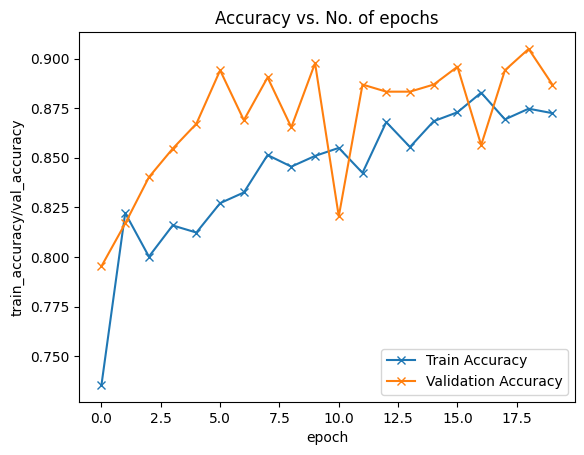

In [35]:
plot_accuracies(mini_vggnet_history)

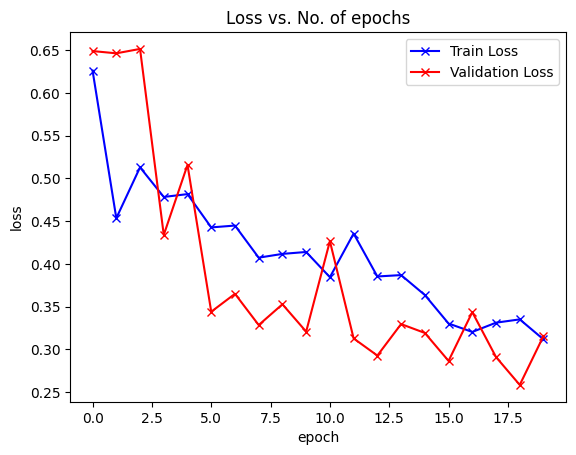

In [36]:
plot_losses(mini_vggnet_history)

## Model 2 - LeNet

### LeNet Build

In [37]:
class LeNet:
    @staticmethod
    def build(width: int, height: int, depth: int) -> Sequential:  # -> Any:
        inputShape = (height, width, depth)

        # initialize the model
        return Sequential([
            Input(shape=inputShape),
            # first set of CONV => RELU => POOL layers
            Conv2D(20, (5, 5), padding='same',  activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.25),

            # second set of CONV => RELU => POOL layers
            Conv2D(50, (5, 5), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Dropout(0.25),

            Flatten(),
            Dropout(0.5),
            Dense(500, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid'),
        ])

In [38]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 /
          40, momentum=0.9, nesterov=True)
Lenet_model = LeNet.build(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
Lenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 20)   │         1,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 50)   │        25,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    78,400,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,427,571 (299.18 MB)

 Trainable params: 78,427,571 (299.18 MB)

 Non-trainable params: 0 (0.00 B)

### LeNet Train

In [39]:

Lenet_model.compile(loss="binary_crossentropy", optimizer=opt,
                    metrics=["accuracy", "precision", "recall"])

# train the network
Lenet_model_history = Lenet_model.fit(train_dataset_prefetch,
                                      validation_data=val_dataset_prefech,
                                      batch_size=params_config.train.batch_size,
                                      epochs=20,
                                      verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.8058 - loss: 0.5418 - precision: 0.8309 - recall: 0.9654 - val_accuracy: 0.8618 - val_loss: 0.4286 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8439 - loss: 0.4459 - precision: 0.8439 - recall: 1.0000 - val_accuracy: 0.8618 - val_loss: 0.4061 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.8352 - loss: 0.4563 - precision: 0.8352 - recall: 1.0000 - val_accuracy: 0.8618 - val_loss: 0.4045 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.8318 - loss: 0.4606 - precision: 0.8318 - recall: 1.0000 - val_accuracy: 0.8618 - val_loss: 0.3922 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8485 - loss: 0.4227 - precision: 0.8485 - recall: 1.0000 - val_accuracy: 0.8618 - val_loss: 0

### LeNet Evaluate

In [40]:
# evaluate the network
letnet_y_pred = predict(Lenet_model)
letnet_y_pred[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[1],
       [1],
       [1],
       [0],
       [0]])

In [41]:
letnet_report = classification_report(
    y_test, letnet_y_pred, target_names=label_names)
print(letnet_report)

              precision    recall  f1-score   support

   Ambulance       0.24      0.83      0.37        77
         Car       0.95      0.57      0.72       480

    accuracy                           0.61       557
   macro avg       0.60      0.70      0.54       557
weighted avg       0.86      0.61      0.67       557



### LeNet Result Plot

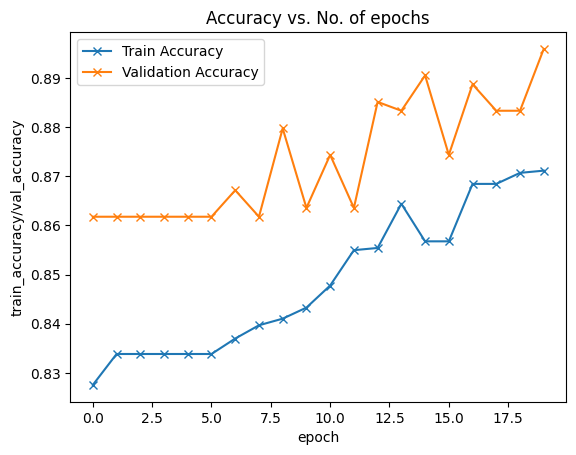

In [42]:
plot_accuracies(Lenet_model_history)

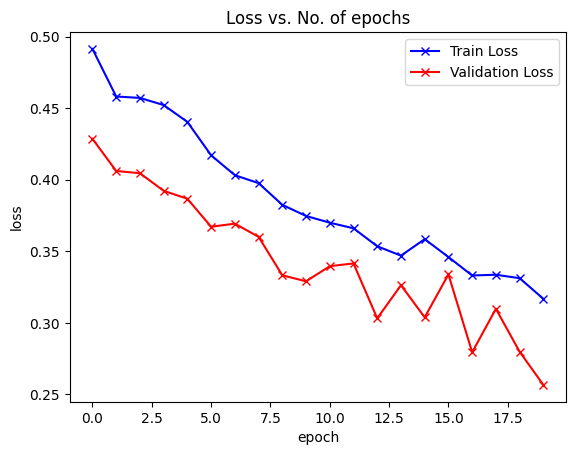

In [43]:
plot_losses(Lenet_model_history)

## Model 3 - Shallownet

### Shallownet Build

In [44]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # channels last
        input_shape = (height, width, depth)

        # define the first and only CONV => RELU layer
        model = Sequential(
            [
                Input(shape=input_shape),
                Conv2D(32, (3, 3),
                       padding="same",  activation='relu'),
                Flatten(),
                Dense(1, activation='sigmoid'),
            ]
        )
        return model

In [45]:
opt = SGD(learning_rate=1e-2, weight_decay=0.01 /
          40, momentum=0.9, nesterov=True)
shallownet_model = ShallowNet.build(
    width=IMAGE_SIZE, height=IMAGE_SIZE, depth=3)
shallownet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1605632)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │     1,605,633 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,606,529 (6.13 MB)

 Trainable params: 1,606,529 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

### Shallownet Train

In [46]:

shallownet_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[
                         "accuracy", "precision", "recall"])

# train the network
shallownet_model_history = shallownet_model.fit(train_dataset_prefetch,
                                                validation_data=val_dataset_prefech,
                                                batch_size=BATCH_SIZE,
                                                epochs=20,
                                                verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.7784 - loss: 1.6281 - precision: 0.8353 - recall: 0.9155 - val_accuracy: 0.8618 - val_loss: 0.3920 - val_precision: 0.8618 - val_recall: 1.0000
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.8238 - loss: 0.4544 - precision: 0.8292 - recall: 0.9915 - val_accuracy: 0.8689 - val_loss: 0.3805 - val_precision: 0.8707 - val_recall: 0.9958
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8460 - loss: 0.4130 - precision: 0.8492 - recall: 0.9938 - val_accuracy: 0.8689 - val_loss: 0.3696 - val_precision: 0.8707 - val_recall: 0.9958
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.8324 - loss: 0.4291 - precision: 0.8372 - recall: 0.9897 - val_accuracy: 0.8761 - val_loss: 0.4122 - val_precision: 0.8870 - val_recall: 0.9812
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.8398 - loss: 0.4312 - precision: 0.8418 - recall: 0.9930 - val_accuracy: 0.8618 - val_loss: 0

### Shallownet Evaluate

In [47]:
# evaluate the network
shallownet_y_pred = predict(shallownet_model)
shallownet_y_pred[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[1],
       [1],
       [0],
       [0],
       [0]])

In [48]:
shallownet_report = classification_report(
    y_test, shallownet_y_pred, target_names=label_names)
print(shallownet_report)

              precision    recall  f1-score   support

   Ambulance       0.21      0.83      0.34        77
         Car       0.95      0.51      0.66       480

    accuracy                           0.55       557
   macro avg       0.58      0.67      0.50       557
weighted avg       0.85      0.55      0.62       557



### Shallownet Result Plot

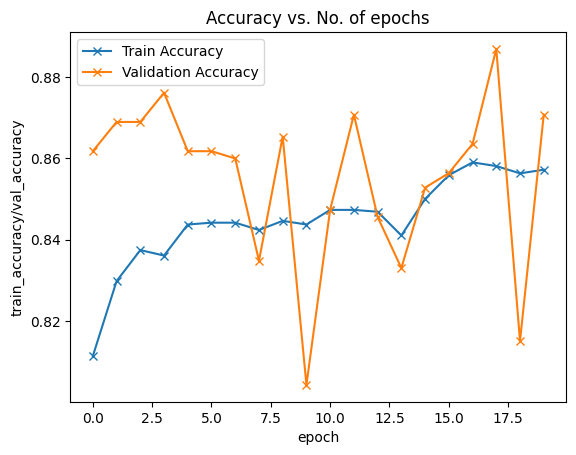

In [49]:
plot_accuracies(shallownet_model_history)

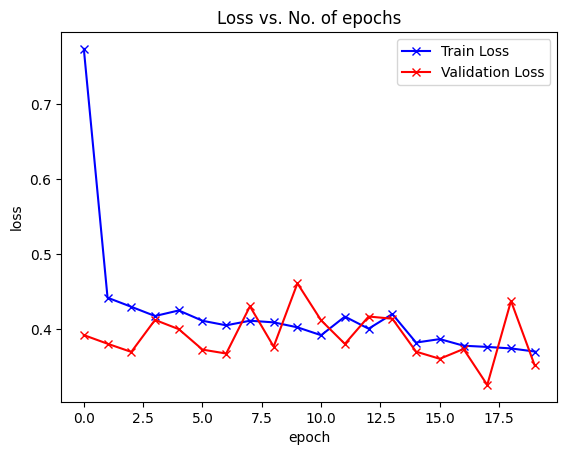

In [50]:
plot_losses(shallownet_model_history)

## Ensemble all the CNNs

In [51]:
def final_predictions(model_list, X_test=X_test):
    # average the probabilities across all model predictions,
    total_pred = []
    for model in model_list:
        total_pred.append(model.predict(
            X_test, batch_size=params_config.train.batch_size))
    mean_pred = np.mean(total_pred, axis=0)
    return (mean_pred > 0.5).astype(int)

In [52]:
model_list = [mini_vggnet_model, Lenet_model, shallownet_model]
final_preds = final_predictions(model_list=model_list)
final_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[1],
       [1],
       [1],
       [0],
       [0]])

In [53]:
print(classification_report(y_test, final_preds, target_names=label_names))

              precision    recall  f1-score   support

   Ambulance       0.28      0.74      0.40        77
         Car       0.94      0.69      0.80       480

    accuracy                           0.69       557
   macro avg       0.61      0.71      0.60       557
weighted avg       0.85      0.69      0.74       557



### Predict on unseen Images

In [54]:
TEST_DIR = '../test_images'

In [55]:
test_image_list = [cv2.imread(f"{TEST_DIR}/{img}")
                   for img in os.listdir(TEST_DIR)]
test_image_list[0]

Invalid SOS parameters for sequential JPEG


array([[[  8,   7,  23],
        [  8,   7,  23],
        [  9,   8,  24],
        ...,
        [ 93, 101, 100],
        [ 90,  98,  97],
        [ 87,  95,  94]],

       [[  8,   7,  23],
        [  8,   8,  22],
        [  9,   8,  24],
        ...,
        [ 94, 102, 101],
        [ 90,  98,  97],
        [ 87,  95,  94]],

       [[  8,   8,  22],
        [  8,   8,  20],
        [  9,   9,  23],
        ...,
        [ 94, 102, 101],
        [ 91,  99,  98],
        [ 88,  96,  95]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3]],

       [[101, 101, 101],
        [101, 101, 101],
        [101, 101, 101],
        ...,
        [101, 101, 101],
        [101, 101, 101],
        [101, 101, 101]]

In [56]:

resize_and_rescale = Sequential([
    Resizing(params_config.train.image_size, params_config.train.image_size),
    Rescaling(1./255)
])

In [57]:

def ensemble_test(image_list):
    fig, axs = plt.subplots(figsize=(10, 10), nrows=len(image_list), ncols=1)

    # Handle case where there is only one image
    if len(image_list) == 1:
        axs = [axs]

    for ax, img in zip(axs, image_list):
        ax.imshow(img)
        _img = resize_and_rescale(img)

        image_with_batch = tf.expand_dims(_img, axis=0)
        predicted = final_predictions(
            model_list=model_list, X_test=image_with_batch)
        # Assuming predicted is a tensor with the label index
        label = label_names[predicted[0][0]]

        ax.axis('off')
        ax.set_title(f'Predicted: {label}')
        print(f'Label: {label}, Predicted: {predicted[0][0]}')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Label: Car, Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Label: Ambulance, Predicted: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Label: Car, Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Label: Car, Predicted: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Label: Car, Predicted: 1


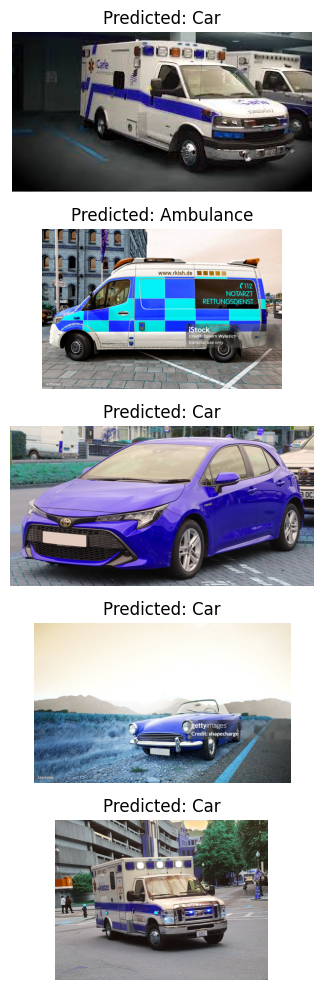

In [58]:
ensemble_test(test_image_list)